# Tangent Linear Code と Adjoint Code を整理しながら書いてみる

# はじめに

## 環境要件


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print(f"numpy: {np.__version__}")

numpy: 1.24.3


## Tangent Linear Code と Adjoint Code の定義

状態空間ベクトル $\vec{x}$ に対する非線形な演算子 $\mathcal{M}$ が与えられたとする。

$$
\vec{y} = \mathcal{M} (\vec{x}) , 
\qquad \vec{x} \in \mathbb{R}^{J}, 
\quad \vec{y} \in \mathbb{R}^{N}.
$$

| 例 | |
|----|-|
| 観測演算子 $\tilde{\mathcal{H}}$ | $\vec{y}^b_i = \tilde{\mathcal{H}} (\vec{x}^f_i)$ |
| 時間発展モデル $\mathcal{M}$ | $\vec{x}^f _{i+1} = \mathcal{M} (\vec{x}^a _{i})$ |

### Tangent Linear model

入力の微小な擾乱に対する出力の応答

$$
\vec{y} + \delta{ \vec{y} } = \mathcal{ M } ( \vec{x} + \delta \vec{x} ).
$$

が線型であると近似する。

$$\delta \vec{y} \approx \mathbf{L} \ \delta \vec{x}.$$

$\mathbf{L}$ はモデル $\mathcal{M}$ を $\vec{x}$ の周りでテイラー展開した時の係数である。

$$
\mathbf{L} = \frac{ \partial \mathcal{M} }{ \partial \vec{x} } \in \mathbb{R}^{N \times J}, 
\qquad \mathrm{L}_{kl} = \frac{ \partial y_k }{ \partial x_l }.
$$

この行列 $\mathbf{L}$ を *接線型モデル (Tangent Linear model, TLM)* という。


### Adjoint model

内積を $\langle \vec{a}, \vec{b} \rangle = a_1 b_1 + a_2 b_2 + \cdots + a_n b_n$ とする。接線型モデル $\mathbf{L}$ に対して

$$\langle \vec{y} , \mathbf{L} \vec{x} \rangle = \langle \mathbf{L}^\dagger \vec{y} , \vec{x} \rangle$$

を満たす行列 $\mathbf{L}^\dagger$ を *随伴モデル (Adjoint model, ADJ)* という。$\mathbf{L}$ が実数値行列であるとき、

$$\mathbf{L}^\dagger = \mathbf{L}^T$$

である。


### アルゴリズム

接線型モデル $\mathbf{L}$ や随伴モデル $\mathbf{L}^T$ は、ビッグデータを扱う場合には大抵ものすごい次元の行列になる。ところが、実際に状態空間モデルを動かす場合には $\mathbf{L}, \mathbf{L}^T$ を何らかのベクトルや行列に掛け合わせるような式が頻出するばかりで、行列データとして $\mathbf{L}, \mathbf{L}^T$ を保持しておくメリットは少ない。

そこで、これらの行列そのもの**ではなく**、これらを作用させた結果だけをうまく計算するプログラムが考え出された。このアルゴリズムを *Tangent Linear Code,  Adjoint Code* という。すなわち、

```python: TangentLinearCode.py
def TangentLinearCode(x0_1, x0_2, ..., x0_J, dx1, dx2, ..., dxJ): #入力 = 基本場 + 摂動
    # アルゴリズム
    Lx = (dy1, dy2, ..., dyN) #TLMと入力ベクトルxの積
    return Lx #出力 = 応答
```

```python: AdjointCode.py
def AdjointCode(x0_1, x0_2, ..., x0_J, dy1, dy2, ..., dyN): #入力 = 基本場 + 応答
    # アルゴリズム
    LTy = (dx1, dx2, ..., dxJ) #ADJと入力ベクトルyの積
    return LTy #出力 = 摂動
```

のようなプログラムになる。

# 例1: 観測演算子 $\mathcal{H}$ の場合

状態変数ベクトル $\vec{x}$ が風速ベクトル ($u$: 東西方向の風速, $v$: 南北方向の風速) であり、観測演算子 $\mathcal{H}$ によってスカラー風速 $y$ を計算する場合を考える。

$$
\vec{x} = 
\begin{pmatrix}
u \cr v
\end{pmatrix}
, \qquad

y = \mathcal{H} (u, v) = \sqrt{u^2 + v^2}
, \qquad

\vec{x} \in \mathbb{R}^{2}
, \quad
y \in \mathbb{R}.
$$ 

In [2]:
def H(u, v):
    y = np.sqrt(u**2 + v**2)
    return y

## Tangent Linear Code

観測演算子 $\mathcal{H}$ を接線型化していこう。

$$
\begin{aligned}
y &= \sqrt{u^2+v^2} \cr
\iff &y^2 = u^2 + v^2
\end{aligned}
$$

基本場と摂動を考えて、

$$(y_0 + \delta y)^2 = (u_0 + \delta u)^2 + (v_0 + \delta v)^2.$$

二次以上の微小量を無視して

$$
\delta y \approx \frac{u_0}{y_0} \delta u + \frac{v_0}{y_0} \delta v.
$$

したがって、TLMは

$$
\mathbf{L} = 
\begin{pmatrix}
\frac{u_0}{y_0} & \frac{v_0}{y_0}
\end{pmatrix}
\in \mathbb{R}^{1 \times 2}.
$$

In [3]:
def TangentLinearCode(u0, v0, du, dv): #入力 = 基本場 + 摂動
    y0 = H(u0, v0) #基本場の情報を取得

    dy = (u0*du + v0*dv) / y0
    return dy #出力 = 応答

## Adjoint Code

TLM の転置を考えて、

$$
\mathbf{L}^T = 
\begin{pmatrix}
\frac{u_0}{y_0} \\[5pt]
\frac{v_0}{y_0}
\end{pmatrix}
\in \mathbb{R}^{2 \times 1}.
$$

In [4]:
def AdjointCode(u0, v0, dy): #入力 = 基本場 + 応答
    y0 = H(u0, v0) #基本場の情報を取得

    du = dy * u0 / y0
    dv = dy * v0 / y0
    return du, dv #出力 = 摂動

## 動作テスト

恒等式

$$ \lVert \mathbf{L} \ \delta \vec{x} \rVert ^2 = \langle \mathbf{L} \ \delta \vec{x}, \ \mathbf{L} \ \delta \vec{x} \rangle = \langle \delta \vec{x}, \ \mathbf{L}^T \mathbf{L} \ \delta \vec{x} \rangle$$

で、

- $\delta \vec{x}$ :  Tangent Linear Code の入力
- $\mathbf{L} \ \delta \vec{x}$ : Tangent Linear Code の出力
- $\mathbf{L}^T \mathbf{L} \ \delta \vec{x}$ : Tangent Linear Code の出力を Adjoint Code に入力した結果

となるはずである。また、そもそも TLM が

$$\delta \vec{y} = \mathcal{H}(\vec{x} + \delta \vec{x}) - \mathcal{H}(\vec{x}) \approx \mathbf{L} \ \delta \vec{x}.$$

と近似したものであったことを思い出して、

In [5]:
u0, v0 = 10.0, 5.0
du, dv =  1.0, 2.0

Lx = TangentLinearCode(u0, v0, du, dv)
LTLx_u, LTLx_v = AdjointCode(u0, v0, Lx)

dy_true = H(u0+du, v0+dv) - H(u0, v0)

print(f"{dy_true * dy_true} ~= { Lx * Lx } == {du * LTLx_u + dv * LTLx_v}")

3.4524052577349775 ~= 3.1999999999999997 == 3.2


Tangent Linear Code と Adjoint Code がうまく動いていること、そして厳密な $\delta \vec{y}$ に対して TLM が $O \left( \frac{ |\delta \vec{x}| }{ |\vec{x}_0| } \right) = O(0.1)$ の精度で近似できていることが確認された。

## Singular Vector の視覚化

TLM と ADJ に対して *leading Singular Vector* $\vec{v}_1$ と 実数 $\sigma_1$ が存在して、次を満たす。

$$(\mathbf{L}^T \mathbf{L}) \vec{v}_1 = \sigma_1 ^{~2} \vec{v}_1$$

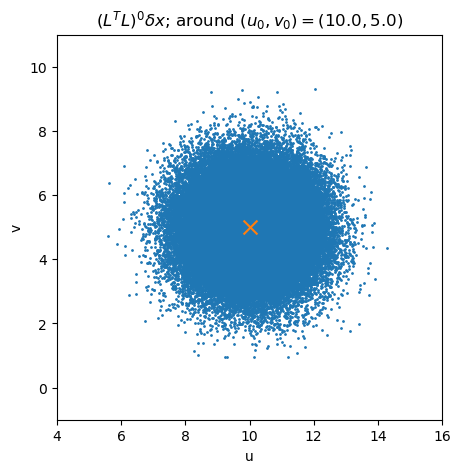

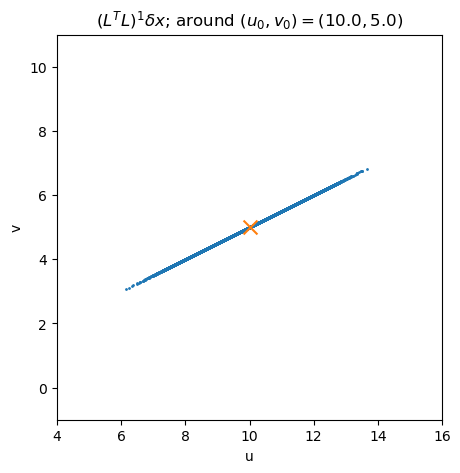

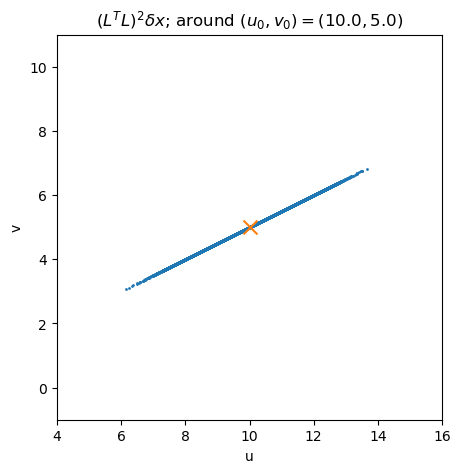

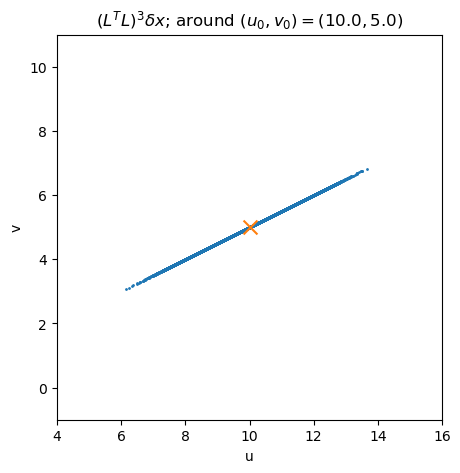

In [6]:
m = 100000
u0, v0 = 10.0, 5.0
dx_list = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], m)

for itr in range(4):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.scatter(u0 + dx_list[:, 0], v0 + dx_list[:, 1], s=1, c="C0")
    ax.scatter([u0], [v0], marker="x", c="C1", s=100)

    ax.set_xlim(u0-6, u0+6)
    ax.set_ylim(v0-6, v0+6)
    ax.set_xlabel("u")
    ax.set_ylabel("v")
    ax.set_title(f"$(L^T L)^{itr} \delta x$; around $(u_0, v_0) = ({u0}, {v0})$")
    ax.set_aspect("equal")
    plt.show()
    nx_dx_list = np.zeros((m, 2))
    for k, dx in enumerate(dx_list):
        Lx = TangentLinearCode(u0, v0, dx[0], dx[1])
        LTLx_u, LTLx_v = AdjointCode(u0, v0, Lx)
        nx_dx_list[k, 0], nx_dx_list[k, 1] = LTLx_u, LTLx_v
    dx_list = nx_dx_list

u0 = -20.0, v0 = -20.0
u0 = -10.0, v0 = -20.0
u0 = 0.0, v0 = -20.0
u0 = 10.0, v0 = -20.0
u0 = 20.0, v0 = -20.0
u0 = -20.0, v0 = -10.0
u0 = -10.0, v0 = -10.0
u0 = 0.0, v0 = -10.0
u0 = 10.0, v0 = -10.0
u0 = 20.0, v0 = -10.0
u0 = -20.0, v0 = 0.0
u0 = -10.0, v0 = 0.0
u0 = 0.0, v0 = 0.0
u0 = 10.0, v0 = 0.0
u0 = 20.0, v0 = 0.0
u0 = -20.0, v0 = 10.0
u0 = -10.0, v0 = 10.0
u0 = 0.0, v0 = 10.0
u0 = 10.0, v0 = 10.0
u0 = 20.0, v0 = 10.0
u0 = -20.0, v0 = 20.0
u0 = -10.0, v0 = 20.0
u0 = 0.0, v0 = 20.0
u0 = 10.0, v0 = 20.0
u0 = 20.0, v0 = 20.0


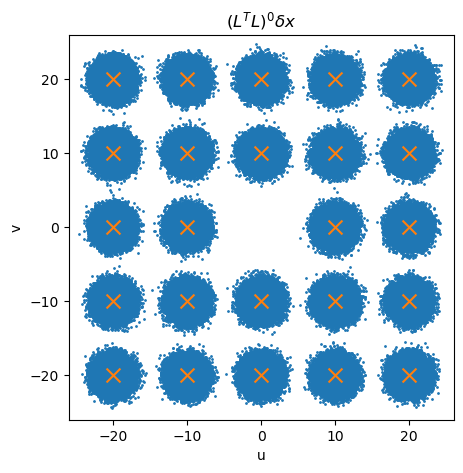

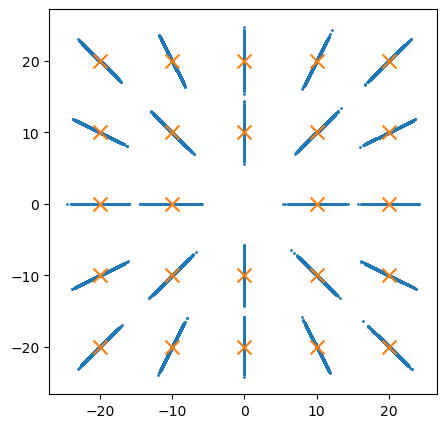

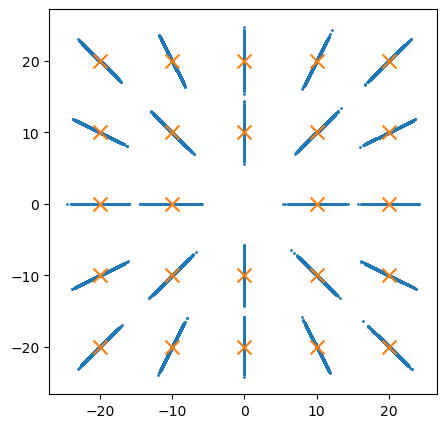

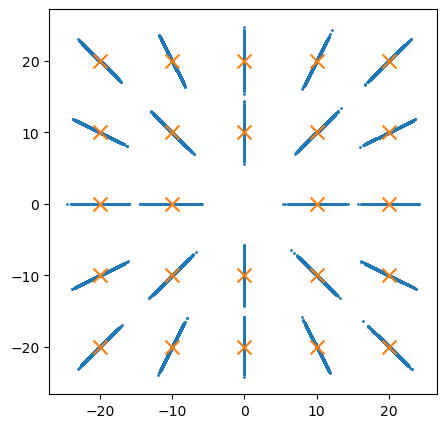

In [7]:
u0_list = np.linspace(-20, 20, 5, endpoint=True)
v0_list = np.linspace(-20, 20, 5, endpoint=True)
u0_grid, v0_grid = np.meshgrid(u0_list, v0_list)

itr_max = 4
m = 100000

figs, axs = [], []

for itr in range(itr_max):
    fig = plt.figure(figsize=(5, 5))
    ax  = fig.add_subplot(111)
    figs.append(fig)
    axs.append(ax)

for u0, v0 in zip(u0_grid.flatten(), v0_grid.flatten()):
    print(f"u0 = {u0}, v0 = {v0}")

    if u0 == 0 and v0 == 0:
        continue

    dx_list = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], m)

    for itr in range(itr_max):
        axs[itr].scatter(u0 + dx_list[:, 0], v0 + dx_list[:, 1], s=1, c="C0")
        axs[itr].scatter([u0], [v0], marker="x", c="C1", s=100)

        nx_dx_list = np.zeros((m, 2))
        for k, dx in enumerate(dx_list):
            Lx = TangentLinearCode(u0, v0, dx[0], dx[1])
            LTLx_u, LTLx_v = AdjointCode(u0, v0, Lx)
            nx_dx_list[k, 0], nx_dx_list[k, 1] = LTLx_u, LTLx_v
        dx_list = nx_dx_list

for itr in range(itr_max):
    # figs[itr].savefig(f"figures/TLC_AdjC_itr{itr}.png", dpi=200)
    axs[itr].set_xlim(-26, +26)
    axs[itr].set_ylim(-26, +26)
    axs[itr].set_xlabel("u")
    axs[itr].set_ylabel("v")
    axs[itr].set_title(f"$(L^T L)^{itr} \delta x$")
    axs[itr].set_aspect("equal")
    plt.show()

# 例2: 時間発展モデル $\mathcal{M}$ の場合

状態変数ベクトル $\vec{x}$ が Lorenz-63 モデルにしたがって時間発展するとする。

$$
\vec{x} = 
\begin{pmatrix}
x(t) \cr y(t) \cr z(t)
\end{pmatrix}
\in \mathbb{R}^{3}
, \qquad

\frac{ \mathrm{d} \vec{x} }{\mathrm{d} t} = F_\mathrm{L63} (t, \vec{x})

\iff

\left\lbrace
\begin{aligned}
& \frac{\mathrm{d} x}{\mathrm{d} t}=10(y-x), \\[10pt]
& \frac{\mathrm{d} y}{\mathrm{d} t}=x(28-z)-y \\[10pt]
& \frac{\mathrm{d} z}{\mathrm{d} t}=x y-\frac{8}{3} z .
\end{aligned}
\right.
$$

ただし、時間発展は時間グリッドを $\Delta t = 0.05$ にとった 4次の Runge-Kutta 法で数値的に積分して求めるものとする。

$$
\mathrm{RK4} \left( F (t_i, \ \vec{x}_i) \right)
\iff 
\left\lbrace \begin{aligned}
& \vec{k_1} = F\left(t_i, \ \vec{x}_i\right), \cr
& \vec{k_2} = F\left(t_i+\frac{\Delta t}{2}, \ \vec{x}_i+\frac{\Delta t}{2} \cdot k_1\right), \cr
& \vec{k_3} = F\left(t_i+\frac{\Delta t}{2}, \ \vec{x}_i+\frac{\Delta t}{2} \cdot k_2\right), \cr
& \vec{k_4} = F\left(t_i+\Delta t, \ \vec{x}_n+\Delta t \cdot k_3\right).
\end{aligned} \right.
$$

$$
\vec{x}_{i+1} 
= \vec{x}_i + \Delta \vec{x}_i, \qquad
\Delta \vec{x}_i = \frac{\Delta t}{6}\left(\vec{k_1} + 2 \vec{k_2} + 2 \vec{k_3} + \vec{k_4} \right)
$$

時間発展のモデル $\mathcal{M}(t, \cdot)$ は、運動方程式としての Lorentz-63 モデル $F_\mathrm{L63}(t, \cdot)$ ではなく、系の情報を一ステップ分進める数値積分全体としての $\mathrm{RK4} (F_\mathrm{L63} (t, \cdot))$ である。

$$
\vec{x}_{i+1} = \mathcal{M} (t, \vec{x}_i) = \mathrm{RK4} (F_\mathrm{L63} (t_i, \vec{x}_i))
$$

In [8]:
def lorenz63(X, s=10, r=28, b=8/3):
    x, y, z = X # vector X = [x, y, z]

    dx = s * (y - x)
    dy = r * x - y - x * z
    dz = x * y - b * z
    return np.array([dx, dy, dz])

In [9]:
def rk4_step(X, Func, Dt=0.05):
    k_weight = np.zeros((4, 3))

    k_weight[0, :] = K1 = Func(X)
    k_weight[1, :] = K2 = Func(X + K1 * Dt / 2)
    k_weight[2, :] = K3 = Func(X + K2 * Dt / 2)
    k_weight[3, :] = K4 = Func(X + K3 * Dt)

    DX = (K1 + 2 * K2 + 2 * K3 + K4) * Dt / 6
    return DX, k_weight

In [10]:
def M(ti, Xi, Dt=0.05):
    DX, k_weight = rk4_step(Xi, lorenz63, Dt=Dt)
    return Xi + DX, k_weight

In [11]:
nX, k_weight = M(0, np.array([1, 1, 1]))

print(f"nX: {nX}")
print(f"k_weight: \n {k_weight}")

nX: [1.29144907 2.39393332 0.96345562]
k_weight: 
 [[ 0.         26.         -1.66666667]
 [ 6.5        25.39166667 -0.90555556]
 [ 4.72291667 29.77902604 -0.70585098]
 [12.52805469 30.93061294  0.50415358]]


[[<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138a88760>], [<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138b114c0>], [<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138a67c70>], [<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138b5a730>], [<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138b6e3d0>], [<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138b11d00>], [<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138a73370>], [<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138b739d0>], [<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138a67e80>], [<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138ba6ac0>], [<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138b03370>], [<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138bc5ac0>], [<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138b932e0>], [<mpl_toolkits.mplot3d.art3d.Path3DCollection object at 0x138a5fbe0>], [<mpl

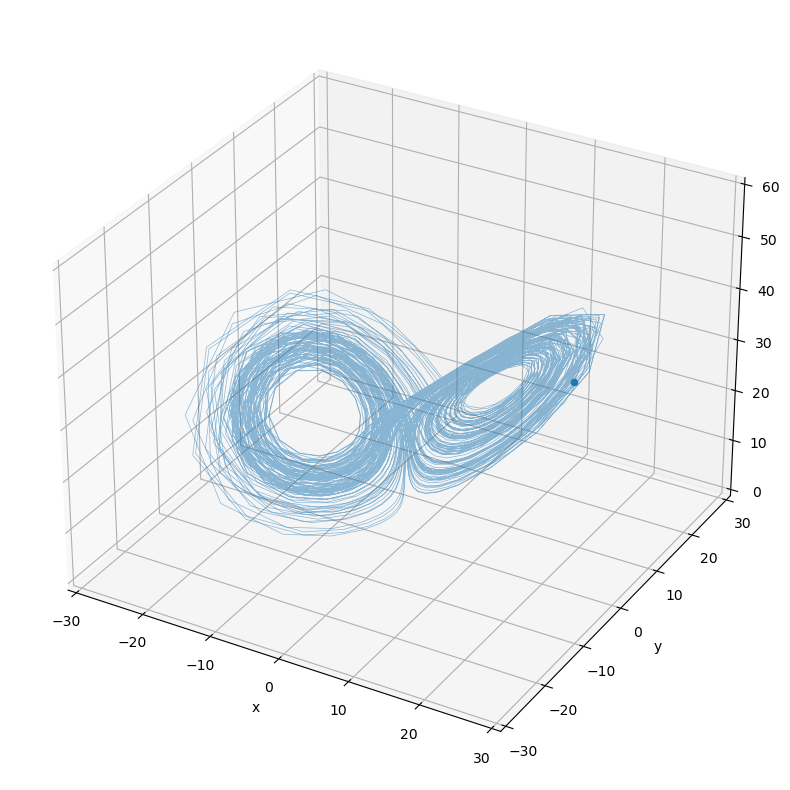

In [12]:
import matplotlib.animation as animation

X_init = np.array([1, 0, 0])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ims = []

X_list = [X_init]

t_spinup = np.array(range(0, 1000)) * 0.05

for ti in t_spinup:
    X_list.append(M(ti, X_list[-1])[0])

X_list = [X_list[-1]]

t_integration = np.array(range(1000, 4000)) * 0.05

for ti in t_integration:
    X_list.append(M(ti, X_list[-1])[0])

X_attractor= np.array(X_list)

for i, (px, py, pz) in enumerate(X_list[100:701]):
    plt.cla()
    ax.plot(X_attractor[:, 0], X_attractor[:, 1], X_attractor[:, 2], lw=0.5, c="C0", alpha=0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_xlim(-30, 30)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 60)

    im = ax.scatter(px, py, pz, s=20, c="C0")
    # plt.savefig(f"./anim/lorenz63_{i}.png", dpi=200)
    ims.append([im])

print(ims)

# didn't work
# ani = animation.ArtistAnimation(fig, ims, interval=100)
# ani.save("./lorenz63.gif", writer="pillow", dpi=200)

## Tangent Linear Code

Runge Kutta 法で Lorenz-63 モデルを数値積分をするとき、例えば重み $\vec{k}_3$ を求めるためには $\vec{k}_2, \vec{k}_1$ までの情報を $F_\mathrm{L63}$ に入力する必要がある。
したがって、時間発展 $\mathcal{M}$ の構造を模式的に書き下すと、

$$
\begin{aligned}
\mathcal{M}(t, \cdot) 
&= \mathrm{RK4} (F_\mathrm{L63} (t, \cdot)) \cr

&= \mathrm{RK4}_{[\Delta \vec{x}]} ( 
    \mathrm{RK4}_{[4 \leftarrow 1]} (F_\mathrm{L63} (t, \cdot)) 
    ) \cr

&= \mathrm{RK4}_{[\Delta \vec{x}]} ( 
    \mathrm{RK4}_{[4]} ( F_\mathrm{L63} (t, 
        \mathrm{RK4}_{[3 \leftarrow 1]} (F_\mathrm{L63} (t, \cdot))
        ))
    ) \cr

&= \cdots \cr

&= \mathrm{RK4}_{[\Delta \vec{x}]} (
    \mathrm{RK4}_{[4]} ( F_\mathrm{L63} (t, 
        \mathrm{RK4}_{[3]} ( F_\mathrm{L63} (t, 
            \mathrm{RK4}_{[2]} ( F_\mathrm{L63} (t, 
                \mathrm{RK4}_{[1]} ( F_\mathrm{L63} (t, \cdot) )
            ))
        ))
    ))
)
\end{aligned}
$$

であるから、$\mathcal{M}, \mathrm{RK4}, F_\mathrm{L63}$ の TLM をそれぞれ $\mathbf{M}, \mathbf{L}_\mathrm{RK4}, \mathbf{L}_\mathrm{L63}$ とすると、以下のような行列の積で表せる。

$$
\mathbf{M} 
= \mathbf{L}_{\mathrm{RK4} [\Delta \vec{x}]} 
\cdot \mathbf{L}_{\mathrm{RK4} [4]} \cdot \mathbf{L}_\mathrm{L63}
\cdot \mathbf{L}_{\mathrm{RK4} [3]} \cdot \mathbf{L}_\mathrm{L63}
\cdot \mathbf{L}_{\mathrm{RK4} [2]} \cdot \mathbf{L}_\mathrm{L63}
\cdot \mathbf{L}_{\mathrm{RK4} [1]} \cdot \mathbf{L}_\mathrm{L63}
$$

したがって、Runge Kutta 法による時間発展モデルの Tangent Linear Code を書くためにはまず Lorentz-63 モデルの TLM が必要である。



### Lorenz-63 モデルの TLM

$$
\delta \left( \frac{\mathrm{d} \vec{x}}{\mathrm{d} t} \right)
= \begin{pmatrix}
\delta \dot{x} \\[10pt] \delta \dot{y} \\[10pt] \delta \dot{z}
\end{pmatrix}
\approx \begin{pmatrix}
\frac{\mathrm{d} F_\mathrm{L63}^x }{\mathrm{d} x} & \frac{\mathrm{d} F_\mathrm{L63}^x }{\mathrm{d} y} & \frac{\mathrm{d} F_\mathrm{L63}^x }{\mathrm{d} z} \\[10pt]
\frac{\mathrm{d} F_\mathrm{L63}^y }{\mathrm{d} z} & \frac{\mathrm{d} F_\mathrm{L63}^y }{\mathrm{d} y} & \frac{\mathrm{d} F_\mathrm{L63}^y }{\mathrm{d} z} \\[10pt]
\frac{\mathrm{d} F_\mathrm{L63}^z }{\mathrm{d}x } & \frac{\mathrm{d} F_\mathrm{L63}^z }{\mathrm{d} y} & \frac{\mathrm{d} F_\mathrm{L63}^z }{\mathrm{d} z} 
\end{pmatrix}
\begin{pmatrix}
\delta x \\[10pt] \delta y \\[10pt] \delta z
\end{pmatrix}
= \begin{pmatrix}
-10  & 10 & 0 \\[10pt]
28-z & -1 & -x \\[10pt]
y    & x  & -\frac{8}{3}
\end{pmatrix}
\begin{pmatrix}
\delta x \\[10pt] \delta y \\[10pt] \delta z
\end{pmatrix}
= \mathbf{L}_\mathrm{L63} \ \delta \vec{x}
$$

In [13]:
def l63_tlm(Xi, dX, s=10, r=28, b=8/3): #入力 = 基本場 + 摂動
    xi, yi, zi = Xi # vector Xi = [xi, yi, zi]
    dx, dy, dz = dX # vector dX = [dx, dy, dz]

    dDx =       -s * dx +  s * dy +   0 * dz
    dDy = (r - zi) * dx + -1 * dy + -xi * dz
    dDz =       yi * dx + xi * dy +  -b * dz
    return np.array([dDx, dDy, dDz]) #出力 = 応答

### 時間発展モデル $\mathcal{M}$ の TLM

In [14]:
def TangentLinearCode(ti, Xi, dX, Dt=0.05): #入力 = 基本場(xi, yi, zi) + 摂動(dxi, dyi, dzi)
    nX, k_weight_i = M(ti, Xi, Dt=Dt) #基本場の情報を取得
    K1i, K2i, K3i, K4i = k_weight_i
    
    # tlm( RK4[1] )
    X0_rk0 = Xi.copy() #lorenz63_tlm が感じる基本場
    dDX1 = l63_tlm(X0_rk0, dX)
    dX_rk1 = dX + dDX1 * Dt / 2

    # tlm( RK4[2] )
    X0_rk1 = Xi + K1i * Dt / 2 #lorenz63_tlm が感じる基本場
    dDX2 = l63_tlm(X0_rk1, dX_rk1)
    dX_rk2 = dX + dDX2 * Dt / 2

    # tlm( RK4[3] )
    X0_rk2 = Xi + K2i * Dt / 2 #lorenz63_tlm が感じる基本場
    dDX3 = l63_tlm(X0_rk2, dX_rk2)
    dX_rk3 = dX + dDX3 * Dt

    # tlm( RK4[4] )
    X0_rk3 = Xi + K3i * Dt #lorenz63_tlm が感じる基本場
    dDX4 = l63_tlm(X0_rk3, dX_rk3)

    # tlm( RK4[ΔX] )
    dnX = dX + (dDX1 + 2 * dDX2 + 2 * dDX3 + dDX4) * Dt / 6
    return dnX #出力 = 応答

## Adjoint Code

$$
\begin{aligned}
\mathbf{M}^T 
&= (\mathbf{L}_{\mathrm{RK4} [\Delta \vec{x}]} 
\cdot \mathbf{L}_{\mathrm{RK4} [4]} \cdot \mathbf{L}_\mathrm{L63}
\cdot \mathbf{L}_{\mathrm{RK4} [3]} \cdot \mathbf{L}_\mathrm{L63}
\cdot \mathbf{L}_{\mathrm{RK4} [2]} \cdot \mathbf{L}_\mathrm{L63}
\cdot \mathbf{L}_{\mathrm{RK4} [1]} \cdot \mathbf{L}_\mathrm{L63})^T \cr
&=    \mathbf{L}_\mathrm{L63}^T \cdot \mathbf{L}_{\mathrm{RK4} [1]}^T 
\cdot \mathbf{L}_\mathrm{L63}^T \cdot \mathbf{L}_{\mathrm{RK4} [2]}^T 
\cdot \mathbf{L}_\mathrm{L63}^T \cdot \mathbf{L}_{\mathrm{RK4} [3]}^T 
\cdot \mathbf{L}_\mathrm{L63}^T \cdot \mathbf{L}_{\mathrm{RK4} [4]}^T 
\cdot\mathbf{L}_{\mathrm{RK4} [\Delta \vec{x}]}^T
\end{aligned}
$$


In [15]:
def l63_adj(Xi, dnX, s=10, r=28, b=8/3): #入力 = 基本場 + 応答
    xi,  yi,  zi  = Xi  # vector  Xi = [xi, yi, zi]
    dnx, dny, dnz = dnX # vector dnX = [dxi, dyi, dzi]

    dxi = -s * dnx + (r - zi) * dny + yi * dnz
    dyi =  s * dnx +       -1 * dny + xi * dnz
    dzi =  0 * dnx +      -xi * dny + -b * dnz
    return np.array([dxi, dyi, dzi]) #出力 = 摂動

In [16]:
def AdjointCode(ti, Xi, dnX, Dt=0.05): #入力 = 基本場(xi, yi, zi) + 応答(dxi, dyi, dzi)
    nX, k_weight_i = M(ti, Xi, Dt=Dt) #基本場の情報を取得
    K1i, K2i, K3i, K4i = k_weight_i

    # adj( RK4[ΔX] )
    dX   = dnX.copy()
    dDX4 = dnX * Dt / 6
    dDX3 = dnX * Dt / 3
    dDX2 = dnX * Dt / 3
    dDX1 = dnX * Dt / 6

    # adj( RK4[4] )
    X0_rk3 = Xi + K3i * Dt #lorenz63_adj が感じる基本場
    dX_rk3 = l63_adj(X0_rk3, dDX4)
    dDX3 = dDX3 + dX_rk3 * Dt
    dX += dX_rk3

    # adj( RK4[3] )
    X0_rk2 = Xi + K2i * Dt / 2 #lorenz63_adj が感じる基本場
    dX_rk2 = l63_adj(X0_rk2, dDX3)
    dDX2 = dDX2 + dX_rk2 * Dt / 2
    dX += dX_rk2

    # adj( RK4[2] )
    X0_rk1 = Xi + K1i * Dt / 2 #lorenz63_adj が感じる基本場
    dX_rk1 = l63_adj(X0_rk1, dDX2)
    dDX1 = dDX1 + dX_rk1 * Dt / 2
    dX += dX_rk1

    # adj( RK4[1] )
    X0_rk0 = Xi #lorenz63_adj が感じる基本場
    dX_rk0 = l63_adj(X0_rk0, dDX1)
    dX += dX_rk0
    
    return dX #出力 = 摂動

## 動作テスト

恒等式

$$ \lVert \mathbf{M} \ \delta \vec{x}_i \rVert ^2 = \langle \mathbf{M} \ \delta \vec{x}_i, \ \mathbf{M} \ \delta \vec{x}_i \rangle = \langle \delta \vec{x}_i, \ \mathbf{M}^T \mathbf{M} \ \delta \vec{x}_i \rangle$$

で、

- $\delta \vec{x}_i$ :  Tangent Linear Code の入力
- $\mathbf{M} \ \delta \vec{x}_i$ : Tangent Linear Code の出力
- $\mathbf{M}^T \mathbf{M} \ \delta \vec{x}_i$ : Tangent Linear Code の出力を Adjoint Code に入力した結果

となるはずである。また、そもそも TLM が

$$\delta \vec{x}_{i+1} = \mathcal{M}(\vec{x}_i + \delta \vec{x}) - \mathcal{M}(\vec{x}_i) \approx \mathbf{M} \ \delta \vec{x}_i.$$

と近似したものであったことを思い出して、

In [17]:
X0 = np.array([10, 20, 30])
dX0 = np.array([1, 2, 3])

Lx = l63_tlm(X0, dX0)
LTLx = l63_adj(X0, Lx)

print(f"{np.dot(dX0, LTLx)} == {np.dot(Lx, Lx)}")

2280.0 == 2280.0


In [18]:
X0 = np.array([10, 20, 30])
dX0 = np.array([1, 2, 3])

Mx = TangentLinearCode(0, X0, dX0)
MTMx = AdjointCode(0, X0, Mx)

dX_true = M(0, X0 + dX0)[0] - M(0, X0)[0]

print(f"{np.dot(dX_true, dX_true)} ~= { np.dot(Mx, Mx) } == { np.dot(dX0, MTMx) }")

16.588074147597972 ~= 16.700646822453045 == 16.70064682245304


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

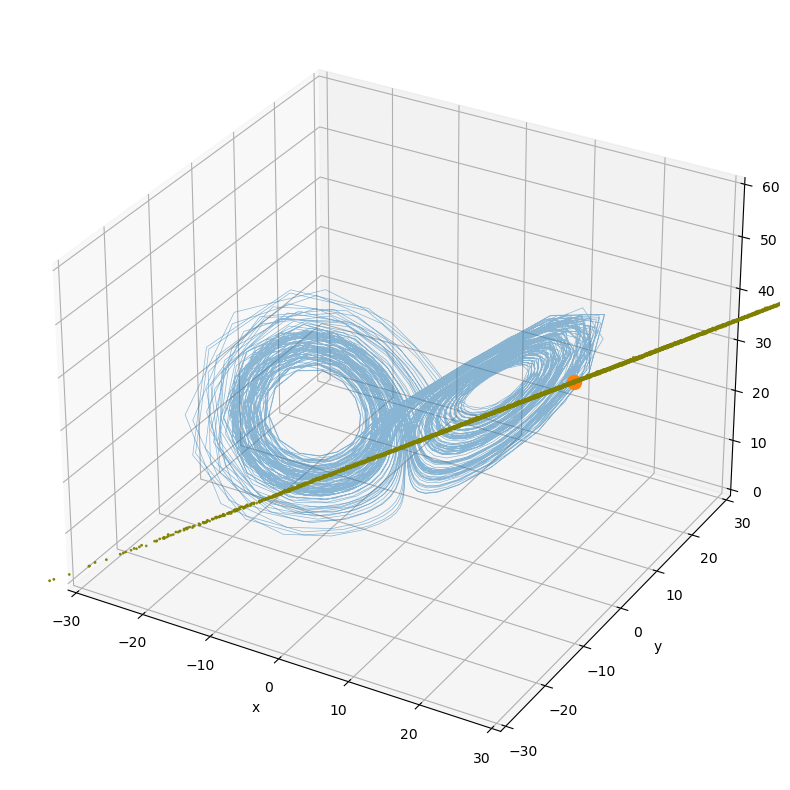

In [20]:
# import matplotlib.animation as animation

X_init = np.array([1, 0, 0])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ims = []

X_list = [X_init]

t_spinup = np.array(range(0, 1000)) * 0.05

for ti in t_spinup:
    X_list.append(M(ti, X_list[-1])[0])

X_list = [X_list[-1]]

t_integration = np.array(range(1000, 4000)) * 0.05

for ti in t_integration:
    X_list.append(M(ti, X_list[-1])[0])

X_attractor= np.array(X_list)


m = 10000
for i, (px, py, pz) in enumerate(X_list[100:701]):
    print(i)
    dX_list = np.random.multivariate_normal([0, 0, 0], [[1, 0, 0], [0, 1, 0], [0, 0, 1]], m)

    for itr in range(5):
        nx_dX_list = np.zeros((m, 3))
        for k, dX in enumerate(dX_list):
            Lx = TangentLinearCode(t_integration[100+i], np.array([px, py, pz]), dX)
            LTLx = AdjointCode(t_integration[100+i], np.array([px, py, pz]), Lx)
            nx_dX_list[k, :] = LTLx
        dX_list = nx_dX_list

    plt.cla()
    # print(dX_list)
    ax.plot(X_attractor[:, 0], X_attractor[:, 1], X_attractor[:, 2], lw=0.5, c="C0", alpha=0.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_xlim(-30, 30)
    ax.set_ylim(-30, 30)
    ax.set_zlim(0, 60)

    ax.scatter(px + dX_list[:, 0], py + dX_list[:, 1], pz + dX_list[:, 2], s=1, c="olive")
    # ax.scatter3D(dX_list[:, 0], dX_list[:, 1], dX_list[:, 2], s=10, c="C1")
    im = ax.scatter(px, py, pz, s=100, c="C1")
    # plt.savefig(f"./anim/lorenz63_SV_{i}.png", dpi=200)
    # ims.append([im])

print(ims)

# didn't work
# ani = animation.ArtistAnimation(fig, ims, interval=100)
# ani.save("./lorenz63.gif", writer="pillow", dpi=200)

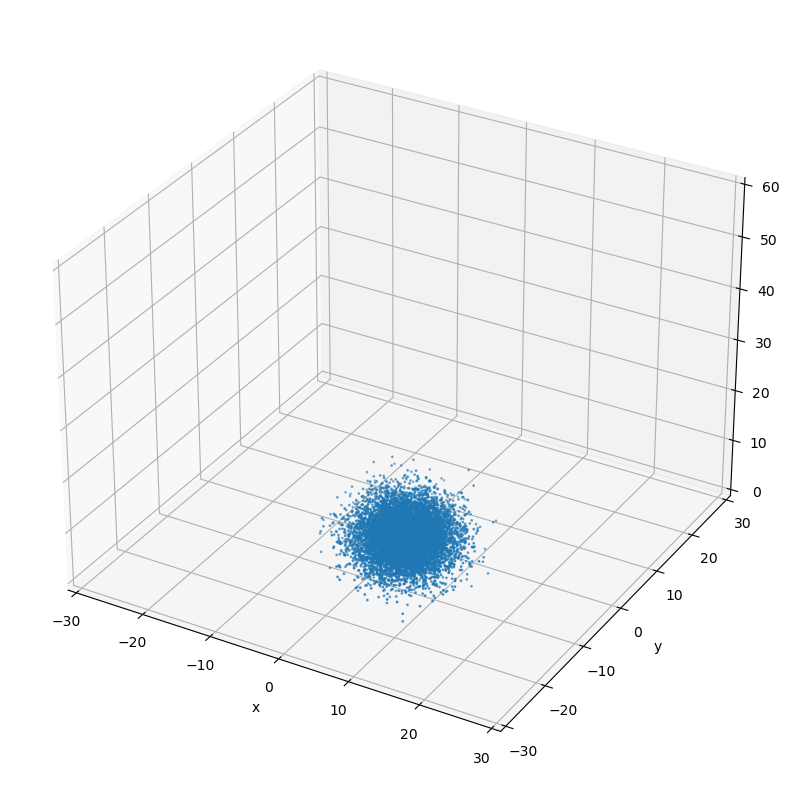

In [21]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

dX_list = np.random.multivariate_normal([0, 0, 0], [[10, 0, 0], [0, 10, 0], [0, 0, 10]], m)
ax.scatter3D(dX_list[:, 0], dX_list[:, 1], dX_list[:, 2], s=1, c="C0")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_zlim(0, 60)

plt.show()